# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (ColumnPreprocessor, 
                                      Transformation, 
                                      InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.evaluation import display_clf_report


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [4]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [5]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [6]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

In [7]:
CONTINUOUS_FEATURES = {
    "name": "multimod", "variables": continuous_set,
    "steps": [("stdscaler", StandardScaler())],
}

DISCRETE_FEATURES = {
    "name": "discrete", "variables": discrete_set,
    "steps": [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
    ],
}

pipeline = ColumnPreprocessor()
pipeline.add_transformation(
    Transformation(**CONTINUOUS_FEATURES)
)
pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)

## Model Threshoding

We will explore probability thresholding with predict_proba and basic pipeline.

In [8]:
reduce_prep_pipe = Pipeline(steps=[
    ('processor', pipeline.create_preprocessor()),
    ('reducer', SelectKBest(k=226, score_func=f_classif)),     
])
    
lr_pipe = Pipeline(steps=[
    ('transformer', reduce_prep_pipe),       
    ('estimator', LogisticRegression(random_state=0))
])
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('processor',
                                  ColumnTransformer(transformers=[('multimod',
                                                                   Pipeline(steps=[('stdscaler',
                                                                                    StandardScaler())]),
                                                                   ['tenure',
                                                                    'monthlycharges',
                                                                    'totalcharges',
                                                                    'partner_paymentmethod_strength']),
                                                                  ('discrete',
                                                                   Pipeline(steps=[('rarecat',
                                                                                    RareCategoryEncoder(tol=0.2)),
                                                                                   ('catencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unk...
                                                                    'gender_internetservice_concat',
                                                                    'gender_onlinesecurity_concat',
                                                                    'gender_onlinebackup_concat',
                                                                    'gender_deviceprotection_concat',
                                                                    'gender_techsupport_concat',
                                                                    'gender_streamingtv_concat',
                                                                    'gender_streamingmovies_concat',
                                                                    'gender_contract_concat',
                                                                    'gender_paperlessbilling_concat', ...])])),
                                 ('reducer', SelectKBest(k=226))])),
                ('estimator', LogisticRegression(random_state=0))])

In [9]:
y_probs = lr_pipe.predict_proba(X_test)[:, 1]

### F1 Scores

In [10]:
thresholds = np.linspace(0, 1, 11)
scores = []
for thres in thresholds:
    churn = y_probs >= thres
    pred = f1_score(y_test, churn)
    scores.append(pred)
    print(f"Threshold: {thres:.2f} - F1 Score: {pred:.3f}")

Threshold: 0.00 - F1 Score: 0.396
Threshold: 0.10 - F1 Score: 0.536
Threshold: 0.20 - F1 Score: 0.580
Threshold: 0.30 - F1 Score: 0.611
Threshold: 0.40 - F1 Score: 0.619
Threshold: 0.50 - F1 Score: 0.599
Threshold: 0.60 - F1 Score: 0.573
Threshold: 0.70 - F1 Score: 0.444
Threshold: 0.80 - F1 Score: 0.117
Threshold: 0.90 - F1 Score: 0.000
Threshold: 1.00 - F1 Score: 0.000


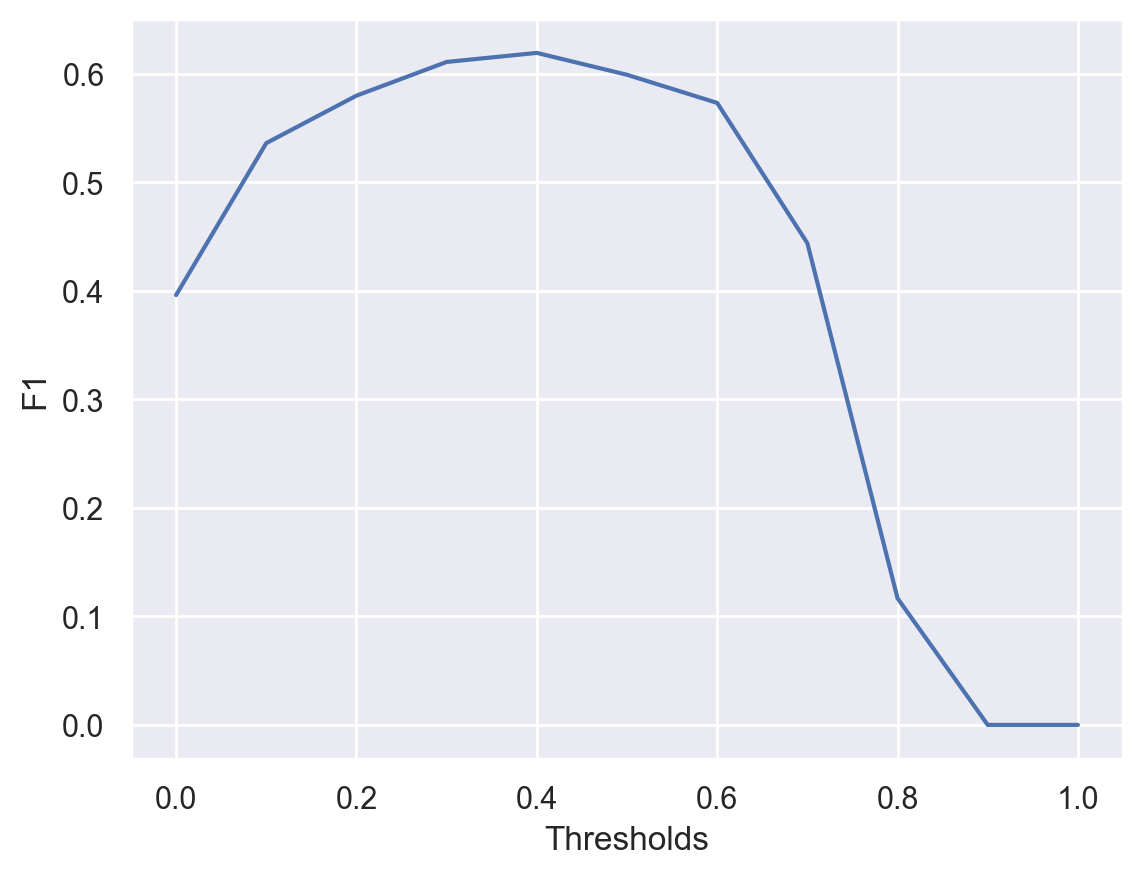

In [11]:
plt.plot(thresholds, scores)
plt.xlabel("Thresholds")
plt.ylabel("F1")
plt.show()

### Recall Scores

In [12]:
thresholds = np.linspace(0, 1, 11)
scores = []
for thres in thresholds:
    churn = y_probs >= thres
    pred = recall_score(y_test, churn)
    scores.append(pred)
    print(f"Threshold: {thres:.2f} - Recall Score: {pred:.3f}")

Threshold: 0.00 - Recall Score: 1.000
Threshold: 0.10 - Recall Score: 0.968
Threshold: 0.20 - Recall Score: 0.897
Threshold: 0.30 - Recall Score: 0.830
Threshold: 0.40 - Recall Score: 0.727
Threshold: 0.50 - Recall Score: 0.629
Threshold: 0.60 - Recall Score: 0.517
Threshold: 0.70 - Recall Score: 0.319
Threshold: 0.80 - Recall Score: 0.063
Threshold: 0.90 - Recall Score: 0.000
Threshold: 1.00 - Recall Score: 0.000


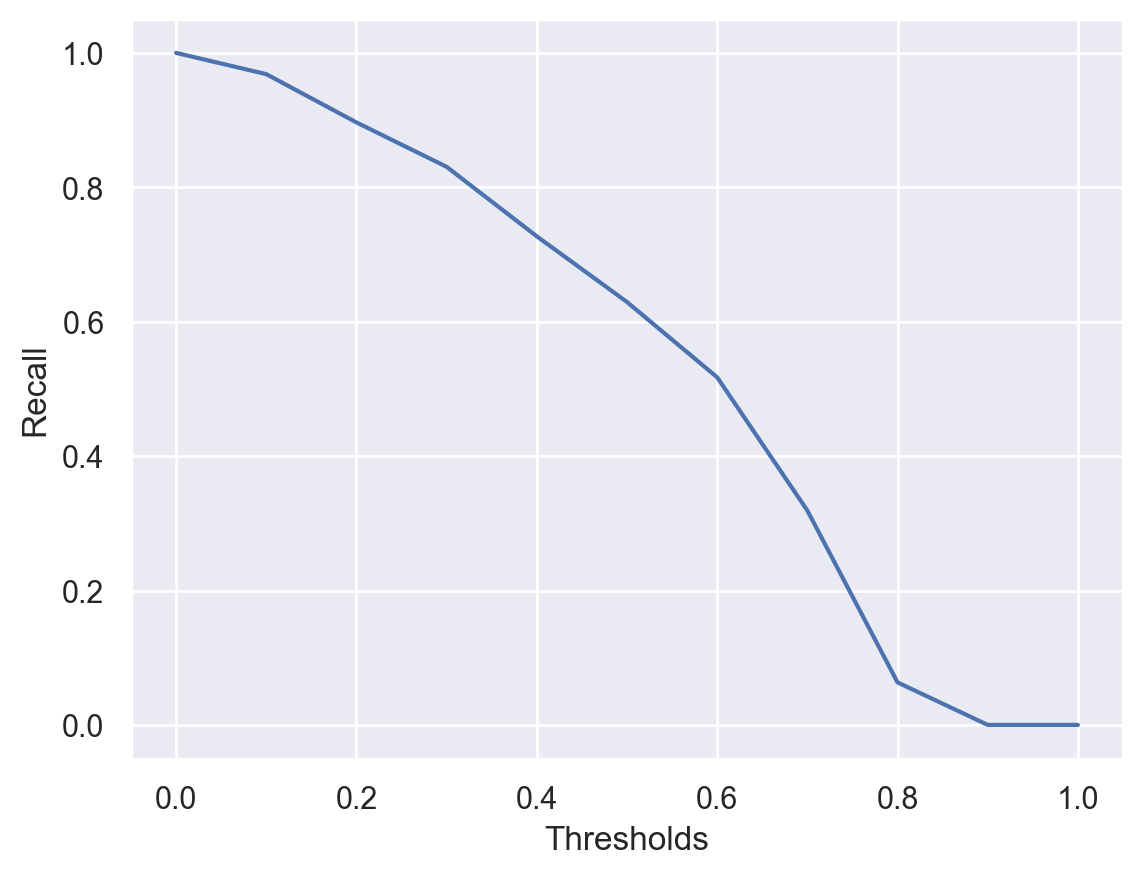

In [13]:
plt.plot(thresholds, scores)
plt.xlabel("Thresholds")
plt.ylabel("Recall")
plt.show()

### Precision Scores

In [14]:
thresholds = np.linspace(0, 1, 11)
scores = []
for thres in thresholds:
    churn = y_probs >= thres
    pred = precision_score(y_test, churn)
    scores.append(pred)
    print(f"Threshold: {thres:.2f} - Precision Score: {pred:.3f}")

Threshold: 0.00 - Precision Score: 0.247
Threshold: 0.10 - Precision Score: 0.371
Threshold: 0.20 - Precision Score: 0.429
Threshold: 0.30 - Precision Score: 0.483
Threshold: 0.40 - Precision Score: 0.539
Threshold: 0.50 - Precision Score: 0.572
Threshold: 0.60 - Precision Score: 0.643
Threshold: 0.70 - Precision Score: 0.730
Threshold: 0.80 - Precision Score: 0.759
Threshold: 0.90 - Precision Score: 0.000
Threshold: 1.00 - Precision Score: 0.000


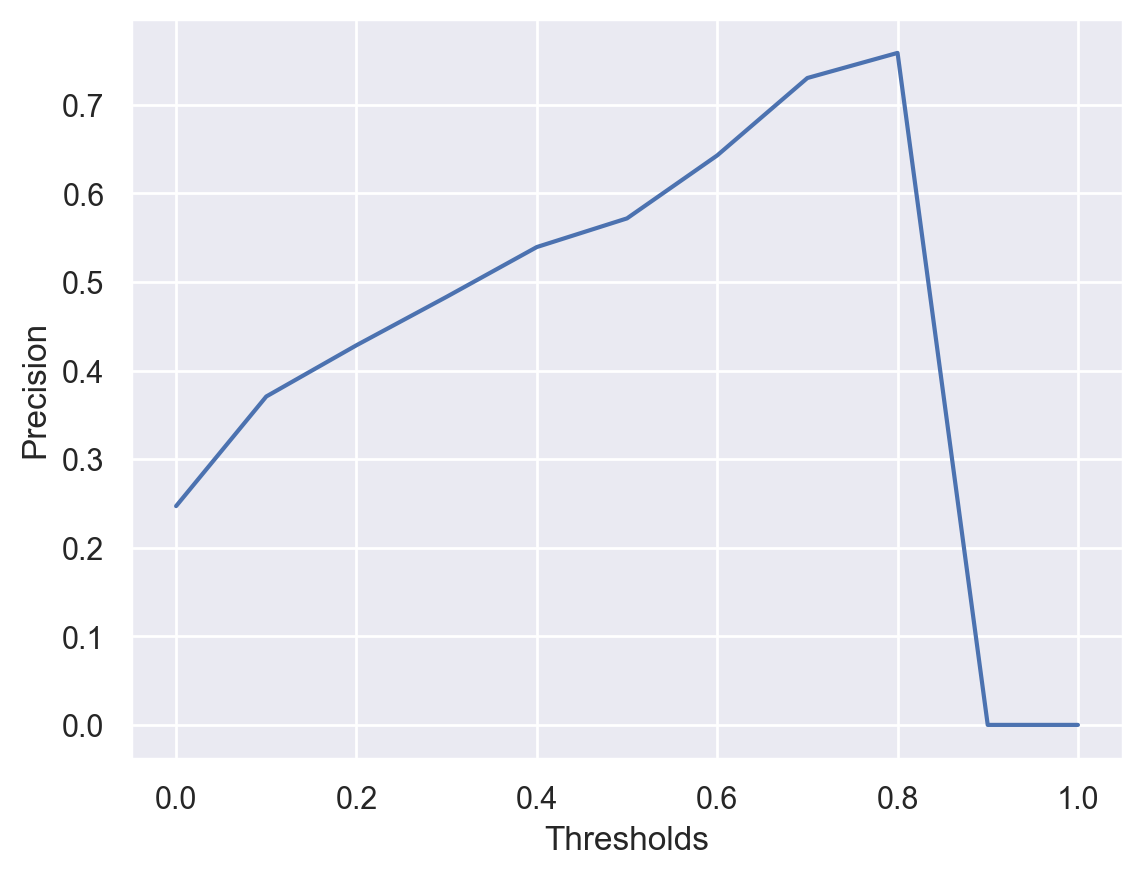

In [15]:
plt.plot(thresholds, scores)
plt.xlabel("Thresholds")
plt.ylabel("Precision")
plt.show()

We can see that a good tradeoff threshold seems to be 0.4

## Best Model on Test Data

In [16]:
test_predictions = (lr_pipe.predict_proba(X_test)[:, 1] >= 0.40).astype("int")

### Classification Report

In [17]:
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1061
           1       0.54      0.73      0.62       348

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.81      0.78      0.79      1409



### Confusion Table

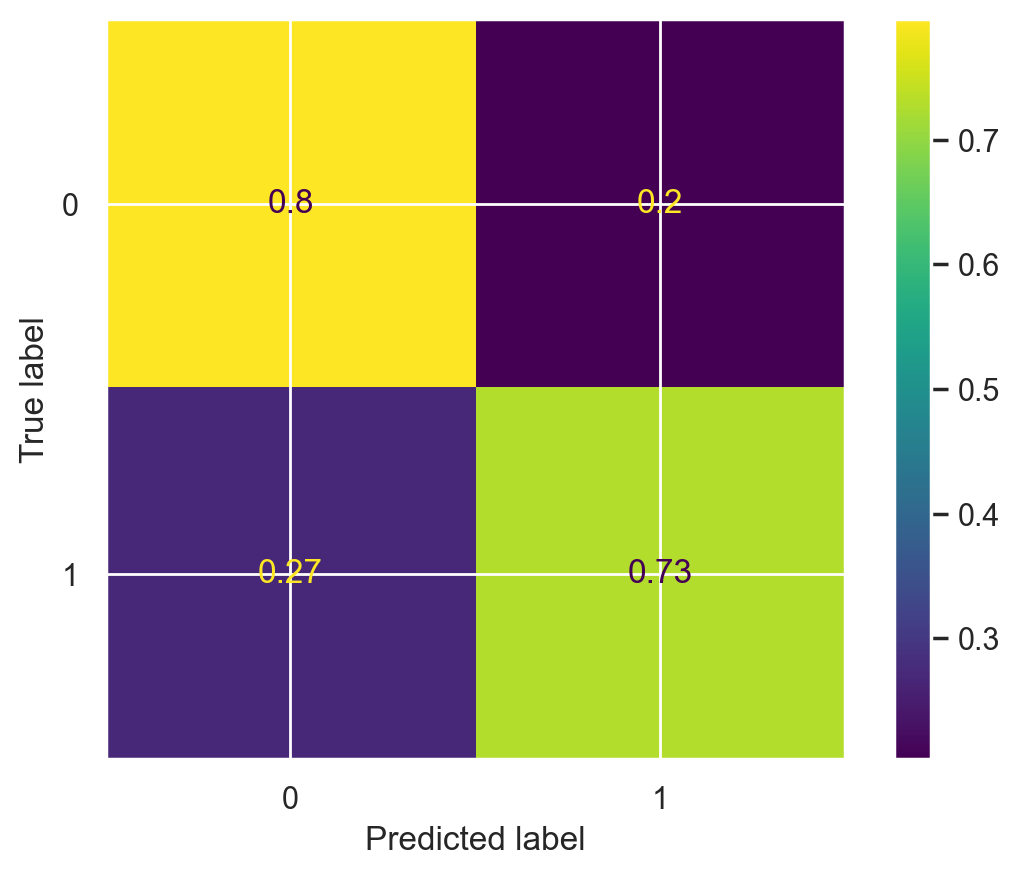

In [18]:
plot_confusion_table(y_test, test_predictions)

Threshold tunning gives better peformance for reaching churned customers but at the cost of losing some true negative cases.<br>
We have a first experiment for exploring thresholding into more advanced pipelines.